In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
import json
from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm

In [2]:
nl_covid = pd.read_csv('../data/Raw/corona/nl_corona.csv',sep='\t')
tests = pd.read_csv('../data/Raw/external/covid-19_tests.csv',sep=';')
weather = pd.read_csv('../data/Raw/weather/weather.csv',sep='\t')
with open('../data/Raw/metadata/nl_metadata.json') as f:
    metadata = json.load(f)
nl_weather = weather['iso3166-2'].str[:2] == 'NL'
nl_weather_df = weather[nl_weather]
nl_weather_df
#missing data?
#print(nl_weather_df.isna().any().any())
nl_weather_df
reg_dict = {}
names = {}
for i in metadata['country_metadata']:
    reg_dict[int(i['covid_region_code'])] = [i['population']]
    names[int(i['covid_region_code'])] = i['iso3166-2_code']
    

reg_names = set(nl_covid['region_code'])
mask1 = nl_covid['confirmed_addition'].dropna()
mask_idk = nl_covid['confirmed_addition'].notnull()

#print(4344-sum(mask_idk))
for i in list(reg_names):
    mask = (nl_covid['region_code'] == i) & (nl_covid['confirmed_addition'].notnull())
    mask_covid=nl_covid[mask]
    reg_dict[i].append(sum(mask_covid['confirmed_addition']))
df1 = pd.DataFrame.from_dict(reg_dict)
df1 = df1.transpose()
final_df = df1.rename(names)

In [3]:
#making a list of all regionnames in tests which should be replaced
#with the nl_covid regions
gelder = ["Gelderland-Midden","Gelderland-Zuid","Noord- en Oost-Gelderland"]
over = ["IJsselland", "Twente"]
#flev = ["Flevoland"]
#Gron = ["Groningen"]
#Zee = ["Zeeland"]
Zhol = ["Haaglanden","Hollands-Midden","Rotterdam-Rijnmond","Zuid-Holland-Zuid"]
Nhol = ["Gooi en Vechtstreek", "Kennemerland", "Noord-Holland-Noord","Zaanstreek-Waterland","Amsterdam-Amstelland"]
#Utrecht = ["Utrecht"]
Lim = ["Limburg-Noord","Limburg-Zuid"]
Nbra = ["Brabant-Noord","Brabant-Zuidoost","Midden- en West-Brabant"]
Frie = ["Fryslân"]
#Dren = ["Drenthe"]
#Remove Onbekend

In [4]:
#Replacing the regionnames with matching regions based on our data
tests["Security_region_name"].replace(gelder,"Gelderland", inplace=True)
tests["Security_region_name"].replace(over,"Overijssel", inplace=True)
tests["Security_region_name"].replace(Zhol,"Zuid-Holland", inplace=True)
tests["Security_region_name"].replace(Nhol,"Noord-Holland", inplace=True)
tests["Security_region_name"].replace(Lim,"Limburg", inplace=True)
tests["Security_region_name"].replace(Nbra,"Noord-Brabant", inplace=True)
tests["Security_region_name"].replace(Frie,"Friesland", inplace=True)

onbekendt_mask = (tests['Security_region_name'] != "Onbekend")

#removing unknown variable with data without a region
tests = tests[onbekendt_mask]

In [5]:
#Changing the date from a string to a datetime class
tests['Date_of_statistics'] = pd.to_datetime(tests["Date_of_statistics"],format= "%d/%m/%Y")
#isolating the weekends
tests['weekend'] = (pd.to_datetime(tests['Date_of_statistics'],format = '%Y-%m-%d').dt.weekday >= 5).astype(int)

In [6]:
'''Finding min, median, max and mean for each numerical value, for each region in the Netherlands.'''
#print(nl_weather_df['iso3166-2'].unique())
num_columns = ['RelativeHumiditySurface','SolarRadiation','Surfacepressure','TemperatureAboveGround','Totalprecipitation','UVIndex','WindSpeed']
reg_dict = {}
for i in nl_weather_df['iso3166-2'].unique():
    reg_dict[i] = {}
    for j in num_columns:
        reg_dict[i][j] = {'min': min(nl_weather_df[nl_weather_df['iso3166-2'] == i][j]),'median':np.median(nl_weather_df[nl_weather_df['iso3166-2'] == i][j]),'max':max(nl_weather_df[nl_weather_df['iso3166-2'] == i][j]),'mean':np.mean(nl_weather_df[nl_weather_df['iso3166-2'] == i][j])}
#reg_dict['NL-GE']['RelativeHumiditySurface']

In [7]:
num_columns = ['RelativeHumiditySurface','SolarRadiation','Surfacepressure','TemperatureAboveGround','Totalprecipitation','UVIndex','WindSpeed']
date_dict = {}
for i in nl_weather_df['date'].unique():
    date_dict[i] = {}
    for j in num_columns:
        date_dict[i][j] = np.mean(nl_weather_df[nl_weather_df['date'] == i][j])
#date_dict

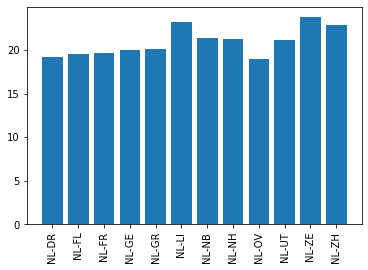

In [8]:
#Plotting means of windspeeds for different regions
means = [reg_dict[i]['UVIndex']['mean'] for i in reg_dict.keys()]

plt.xticks(rotation=90)
plt.bar(reg_dict.keys(),means);

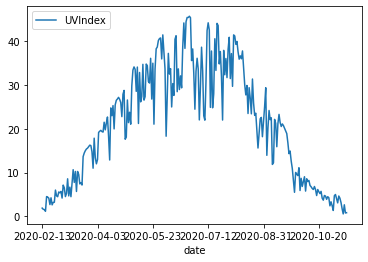

In [9]:
weather_by_day_nl = nl_weather_df.groupby(by = "date").mean()

weather_by_day_nl.loc[:, "UVIndex"].plot.line().legend(loc = "upper left")

In [10]:
#Plotting the map with folium
nl_map = folium.Map(location = [52.3,5.5], zoom_start = 7.4)
folium.GeoJson('../Data/Raw/shapefiles/nl.geojson', name = "geojson").add_to(nl_map)
folium.LayerControl().add_to(nl_map)

nl_map

In [11]:
final_df.columns = ['population', 'cases']
df = final_df.reset_index()
df.columns = ["region",'population', 'cases']

In [12]:
# Fifth task, we create a new column in our data frame with the cases per capita
df["cases_pc"] = df["cases"] / df["population"]*100


nl_map = folium.Map(location = [52.3,5.5], zoom_start = 7.4)
folium.Choropleth(
    geo_data = '../Data/Raw/shapefiles/nl.geojson',
    name = "cases",
    data = df,
    columns = ['region', 'cases_pc'],
    key_on = "properties.iso_3166_2",
    fill_color = "OrRd",
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = "number of cases %",
).add_to(nl_map)

nl_map

In [13]:
with open('../data/Raw/metadata/nl_metadata.json') as f:
    metadata = json.load(f)
nl_weather = weather['iso3166-2'].str[:2] == 'NL'
nl_weather_df = weather[nl_weather]
nl_weather_df
#missing data?
#print(nl_weather_df.isna().any().any())
nl_weather_df
reg_dict = {}
names = {}
for i in metadata['country_metadata']:
    reg_dict[int(i['covid_region_code'])] = [i['population']]
    names[int(i['covid_region_code'])] = i['iso3166-2_code']
    

reg_names = set(nl_covid['region_code'])
mask1 = nl_covid['confirmed_addition'].dropna()
mask_idk = nl_covid['confirmed_addition'].notnull()

#print(4344-sum(mask_idk))
for i in list(reg_names):
    mask = (nl_covid['region_code'] == i) & (nl_covid['confirmed_addition'].notnull())
    mask_covid=nl_covid[mask]
    reg_dict[i].append(sum(mask_covid['confirmed_addition']))
df1 = pd.DataFrame.from_dict(reg_dict)
df1 = df1.transpose()
final_df = df1.rename(names)

In [14]:
mask = nl_covid['confirmed_addition'].notnull()
nl_covid_clean = nl_covid[mask]
nl_covid_clean = nl_covid_clean.drop(['deceased_addition','hospitalized_addition','deceased_cumulative','confirmed_cumulative','hospitalized_cumulative'], axis=1)
region_codes = set(nl_covid_clean['region_code'])

nl_covid_clean['region_code'].replace(list(names.keys()), list(names.values()), inplace=True)

In [15]:
weather_corona = nl_covid_clean.merge(nl_weather_df, left_on=['date','region_code'],right_on=['date','iso3166-2'])
weather_corona.drop(['region_code'],axis=1)


,date,region_name,confirmed_addition,iso3166-2,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed
0,2020-02-28,Drenthe,0.0,NL-DR,85.273843,2.928512e+06,2.418883e+06,276.640094,0.006936,5.311518,5.604625
1,2020-02-28,Flevoland,0.0,NL-FL,84.473753,1.768177e+06,2.419984e+06,277.652467,0.006982,4.339130,7.142621
2,2020-02-28,Friesland,0.0,NL-FR,83.733823,2.235102e+06,2.418199e+06,277.660126,0.009203,4.835275,7.593261
3,2020-02-28,Gelderland,0.0,NL-GE,85.451835,2.148558e+06,2.419307e+06,276.989081,0.005471,5.283174,5.430404
4,2020-02-28,Groningen,0.0,NL-GR,83.629892,3.309977e+06,2.419139e+06,277.065390,0.008450,5.784530,6.361245
...,...,...,...,...,...,...,...,...,...,...,...
3127,2020-11-14,Noord-Holland,890.0,NL-NH,90.139789,3.315327e+05,2.428772e+06,284.412821,0.002788,0.022989,5.937843
3128,2020-11-14,Overijssel,357.0,NL-OV,90.624991,8.355392e+05,2.428846e+06,284.984318,0.001212,0.434870,3.534711
3129,2020-11-14,Utrecht,427.0,NL-UT,89.424252,9.894519e+05,2.429694e+06,285.008331,0.002306,0.135371,4.576365
3130,2020-11-14,Zeeland,80.0,NL-ZE,87.590779,1.583508e+06,2.429062e+06,285.820956,0.002250,2.522796,6.111993


In [16]:
#Testing correlations for numerical variables in combined weather and covid dataframe
num_columns
withoutzeros = weather_corona["confirmed_addition"].clip(lower=1)
sig_thresh = 0.001 / len(num_columns)*3

for var in num_columns:
    corr,p = pearsonr(weather_corona['confirmed_addition'],weather_corona[var])
    corr2,p2 = spearmanr(weather_corona['confirmed_addition'],weather_corona[var])
    corr3,p3 = pearsonr(np.log(withoutzeros),weather_corona[var])
    print('------------ '+var+' --------------')
    print("-----Pearson------")
    print("Correlation",corr)
    print("P value",p,p<sig_thresh)
    print("-----Spearman------")
    print("Correlation", corr2)
    print("P value", p2,p<sig_thresh)
    print("------LOG-------")
    print("Correlation", corr3)
    print("P value", p3,p<sig_thresh)
    print('\n')

------------ RelativeHumiditySurface --------------
-----Pearson------
Correlation 0.25914485045897523
P value 3.088635268628318e-49 True
-----Spearman------
Correlation 0.17119846530118615
P value 4.9886821071058895e-22 True
------LOG-------
Correlation 0.14730970306380725
P value 1.170904138485524e-16 True


------------ SolarRadiation --------------
-----Pearson------
Correlation -0.3031720996839442
P value 1.3813892518461925e-67 True
-----Spearman------
Correlation -0.24919847742881215
P value 1.515594304489898e-45 True
------LOG-------
Correlation -0.2593124095327117
P value 2.6680281188457745e-49 True


------------ Surfacepressure --------------
-----Pearson------
Correlation -0.04955965853428121
P value 0.005534310881026885 False
-----Spearman------
Correlation 0.027537562453286663
P value 0.12336627487089394 False
------LOG-------
Correlation 0.010111651853898816
P value 0.5716114514402791 False


------------ TemperatureAboveGround --------------
-----Pearson------
Correlatio

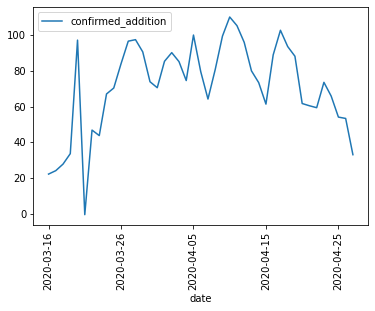

In [17]:
#dataframe containing only cases during spring lockdown
lockdown = (nl_covid['date'] > '2020-03-15') & (nl_covid['date'] < '2020-04-28')

yes = nl_covid[lockdown]
nl_covid_by_day =  yes.groupby(by='date').mean()

nl_covid_by_day.loc[:,'confirmed_addition'].plot.line(rot=90).legend(loc='upper left');

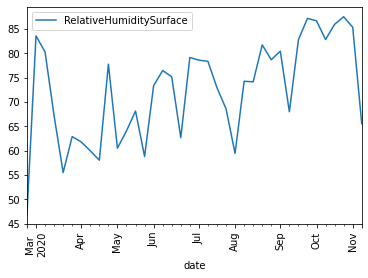

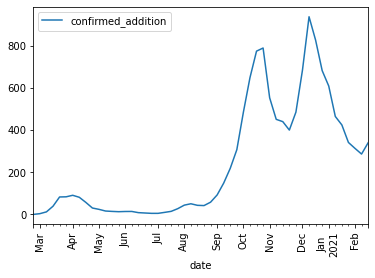

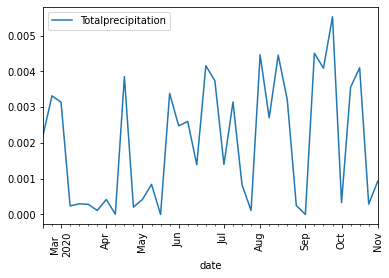

In [18]:
#plotting covid and weather data by weeks, to better visualize data
plt.figure(0)
weather_corona['date'] = pd.to_datetime(weather_corona['date']) - pd.to_timedelta(7, unit='d')
df = weather_corona.groupby(['region_name', pd.Grouper(key='date', freq='W-MON')])['RelativeHumiditySurface'].sum().reset_index().sort_values('date')
df['RelativeHumiditySurface'] = df['RelativeHumiditySurface']/7
nl_covid_by_day =  df.groupby(by='date').mean()
nl_covid_by_day.loc[:,'RelativeHumiditySurface'].plot.line(rot=90).legend(loc='upper left')
plt.figure(1)
nl_covid['date'] = pd.to_datetime(nl_covid['date']) - pd.to_timedelta(7, unit='d')
df = nl_covid.groupby(['region_name', pd.Grouper(key='date', freq='W-MON')])['confirmed_addition'].sum().reset_index().sort_values('date')
df['confirmed_addition'] = df['confirmed_addition']/7
nl_covid_by_day =  df.groupby(by='date').mean()
nl_covid_by_day.loc[:,'confirmed_addition'].plot.line(rot=90).legend(loc='upper left')
plt.figure(2)
weather_corona['date'] = pd.to_datetime(weather_corona['date']) - pd.to_timedelta(7, unit='d')
df = weather_corona.groupby(['region_name', pd.Grouper(key='date', freq='W-MON')])['Totalprecipitation'].sum().reset_index().sort_values('date')
df['Totalprecipitation'] = df['Totalprecipitation']/7
nl_covid_by_day =  df.groupby(by='date').mean()
nl_covid_by_day.loc[:,'Totalprecipitation'].plot.line(rot=90).legend(loc='upper left')

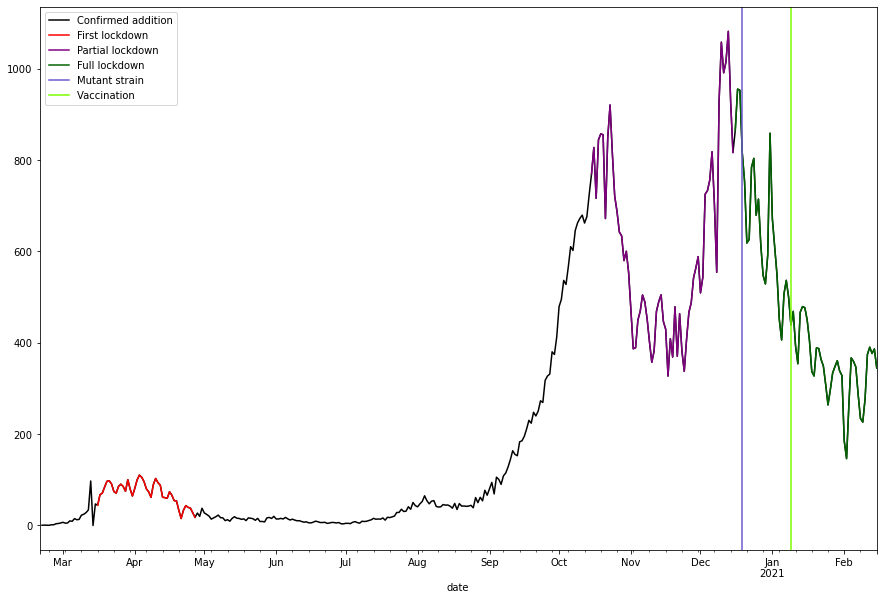

In [19]:
first_lockdown = (nl_covid['date'] > '2020-03-15') & (nl_covid['date'] < '2020-04-28')
october_partial_lockdown = (nl_covid['date'] > '2020-10-14') & (nl_covid['date'] <= '2020-12-15')
hard_december_lockdown = (nl_covid['date'] > '2020-12-15') & (nl_covid['date'] < '2021-03-15')
plt.figure(figsize=(15,10))
nl_covid_by_day =  nl_covid.groupby(by='date').mean()
first_lockdown_by_day = nl_covid[first_lockdown].groupby('date').mean()
october_partial_lockdown_by_day  = nl_covid[october_partial_lockdown].groupby('date').mean()
hard_december_lockdown_by_day  = nl_covid[hard_december_lockdown].groupby('date').mean()

ax = nl_covid_by_day.loc[:,'confirmed_addition'].plot.line(color='k',rot=90,label='Confirmed addition') #covid addition daily
first_lockdown_by_day.loc[:,'confirmed_addition'].plot.line(color ='r',label='First lockdown',ax=ax) #first lockdown
october_partial_lockdown_by_day.loc[:,'confirmed_addition'].plot.line(color ='purple',label='Partial lockdown',ax=ax) #october partial lockdown
hard_december_lockdown_by_day.loc[:,'confirmed_addition'].plot.line(color ='darkgreen',label='Full lockdown',ax=ax) #october partial lockdown
plt.axvline('2020-12-19',label='Mutant strain ',color='slateblue')
plt.axvline('2021-01-09',label='Vaccination ',color='lawngreen')
plt.legend()
plt.show()

In [20]:
region_UVindex = {}

reg_names = set(weather_corona['region_code'])

for name in list(reg_names):
    mask = weather_corona['region_code'] == name
    region_UVindex[name] = [sum(weather_corona[mask]['UVIndex'])/len(weather_corona[mask])]
    #print(sum(weather_corona[mask]['RelativeHumiditySurface'])/len(weather_corona[mask]))



region_humidity_df = pd.DataFrame.from_dict(region_UVindex)
region_humidity_df = region_humidity_df.transpose().reset_index()
region_humidity_df.rename(columns = {'index':'region',0:'AVG UV'}, inplace = True)

In [21]:
#Average humidity by region
nl_map = folium.Map(location = [52.3,5.5], zoom_start = 7.4)
folium.Choropleth(
    geo_data = '../Data/Raw/shapefiles/nl.geojson',
    name = "AVG UV",
    data = region_humidity_df,
    columns = ['region', 'AVG UV'],
    key_on = "properties.iso_3166_2",
    fill_color = "OrRd",
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = "average UV",
).add_to(nl_map)

nl_map


In [22]:
Lockdown_True = (weather_corona['date'] > '2020-03-15') & (weather_corona['date'] < '2020-04-28') | (weather_corona['date'] > '2020-10-14') & (weather_corona['date'] <= '2020-12-15') | (weather_corona['date'] > '2020-12-15') & (weather_corona['date'] < '2021-03-15')
weather_corona['Lockdown'] = list(Lockdown_True)
weather_corona['Lockdown'].replace([True,False],[1,0],inplace = True)

In [23]:
num_columns.append('holiday')
num_columns.append('Lockdown')
num_columns.append('weekend')
num_columns.append('no_school')
weather_corona['weekend'] = 0
weather_corona['weekend'] = (pd.to_datetime(weather_corona['date'],format = '%Y-%m-%d').dt.weekday >= 5).astype(int)
weather_corona['holiday'] = 0

no_school = (weather_corona['date'] > '2020-03-12') & (weather_corona['date']<'2020-06-08')
weather_corona['no_school'] = list(no_school)
weather_corona['no_school'].replace([True,False],[1,0],inplace=True)
weather_corona.loc[weather_corona['date'] == '2020-01-01','holiday'] = 1
weather_corona.loc[weather_corona['date'] == '2020-04-10','holiday'] = 1
weather_corona.loc[weather_corona['date'] == '2020-04-12','holiday'] = 1
weather_corona.loc[weather_corona['date'] == '2020-04-13','holiday'] = 1
weather_corona.loc[weather_corona['date'] == '2020-04-27','holiday'] = 1
weather_corona.loc[weather_corona['date'] == '2020-05-05','holiday'] = 1
weather_corona.loc[weather_corona['date'] == '2020-05-21','holiday'] = 1
weather_corona.loc[weather_corona['date'] == '2020-05-31','holiday'] = 1
weather_corona.loc[weather_corona['date'] == '2020-06-01','holiday'] = 1
weather_corona.loc[weather_corona['date'] == '2020-12-25','holiday'] = 1
weather_corona.loc[weather_corona['date'] == '2020-12-26','holiday'] = 1

In [24]:
df = final_df.reset_index()
df.columns = ["region",'population', 'cases']
weather_corona = weather_corona.merge(df, left_on=['region_code'],right_on=['region'])
weather_corona.drop('region',axis=1)

,date,region_name,region_code,confirmed_addition,iso3166-2,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed,Lockdown,weekend,holiday,no_school,population,cases
0,2020-02-14,Drenthe,NL-DR,0.0,NL-DR,85.273843,2.928512e+06,2.418883e+06,276.640094,0.006936,5.311518,5.604625,0,0,0,0,493657.0,21039.0
1,2020-02-15,Drenthe,NL-DR,0.0,NL-DR,80.257003,2.841131e+06,2.371918e+06,281.328435,0.002324,4.934555,8.246477,0,1,0,0,493657.0,21039.0
2,2020-02-16,Drenthe,NL-DR,1.0,NL-DR,75.513798,4.759941e+06,2.373856e+06,278.924656,0.001929,5.123037,7.386202,0,1,0,0,493657.0,21039.0
3,2020-02-17,Drenthe,NL-DR,0.0,NL-DR,91.237664,5.649723e+05,2.374793e+06,278.098476,0.006125,2.363874,3.540609,0,0,0,0,493657.0,21039.0
4,2020-02-18,Drenthe,NL-DR,1.0,NL-DR,85.908015,6.732560e+06,2.400501e+06,277.428121,0.001744,6.442408,3.668597,0,0,0,0,493657.0,21039.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3127,2020-10-27,Zuid-Holland,NL-ZH,1182.0,NL-ZH,93.763647,1.290511e+06,2.459498e+06,285.417655,0.000869,3.383948,1.955034,1,0,0,0,3708585.0,250759.0
3128,2020-10-28,Zuid-Holland,NL-ZH,1533.0,NL-ZH,94.676392,1.449670e+05,2.452663e+06,284.415953,0.000165,0.993492,3.962166,1,0,0,0,3708585.0,250759.0
3129,2020-10-29,Zuid-Holland,NL-ZH,1526.0,NL-ZH,86.833884,2.698975e+06,2.437308e+06,283.674702,0.002265,2.277657,6.136334,1,0,0,0,3708585.0,250759.0
3130,2020-10-30,Zuid-Holland,NL-ZH,1487.0,NL-ZH,91.831301,3.569254e+05,2.435425e+06,283.096617,0.000671,0.008677,4.770454,1,0,0,0,3708585.0,250759.0


In [25]:
weather_corona['cases_per_c'] = weather_corona['confirmed_addition']/weather_corona['population']
est = sm.OLS(weather_corona['cases_per_c'],weather_corona[num_columns], hasconst = True).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:            cases_per_c   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     186.1
Date:                Tue, 16 Mar 2021   Prob (F-statistic):          5.95e-308
Time:                        18:18:41   Log-Likelihood:                 24050.
No. Observations:                3132   AIC:                        -4.808e+04
Df Residuals:                    3121   BIC:                        -4.801e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
RelativeHumiditySurface  1

In [26]:
#testing external data, maybe done b4 idk lol
est = sm.OLS(tests['Tested_positive'],tests[['Tested_with_result','weekend']], hasconst = True).fit()
print(est.summary())

#Testing correlations for numerical variables in combined weather and covid dataframe

withoutzeros = weather_corona["confirmed_addition"].clip(lower=1)
sig_thresh = 0.000001 / 2

corr,p = pearsonr(tests['Tested_positive'],tests['Tested_with_result'])
corr2,p2 = spearmanr(tests['Tested_positive'],tests['Tested_with_result'])
#corr3,p3 = pearsonr(np.log(tests['Tested_positive']),np.log(tests['Tested_with_result']))

print("-----Pearson------")
print("Correlation",corr)
print("P value",p,p<sig_thresh)
print("-----Spearman------")
print("Correlation", corr2)
print("P value", p2,p<sig_thresh)
print("------LOG-------")
# print("Correlation", corr3)
# print("P value", p3,p<sig_thresh)
# print('\n')


                            OLS Regression Results                            
Dep. Variable:        Tested_positive   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                 1.969e+04
Date:                Tue, 16 Mar 2021   Prob (F-statistic):               0.00
Time:                        18:18:42   Log-Likelihood:                -40972.
No. Observations:                7125   AIC:                         8.195e+04
Df Residuals:                    7123   BIC:                         8.196e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Tested_with_result     0.1132      0

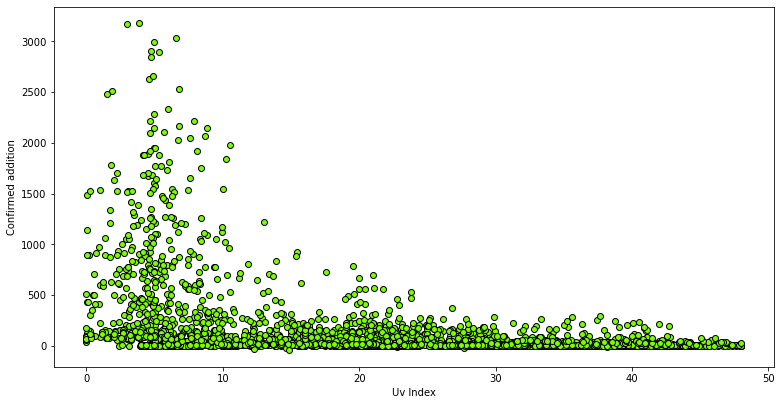

In [27]:
fig = plt.figure(figsize=(10,5))
axes = fig.add_axes([0,0,1,1])
axes.set_xlabel('Uv Index')
axes.set_ylabel('Confirmed addition')
m,b,c,d = np.polyfit(weather_corona['UVIndex'], weather_corona['confirmed_addition'],3)
#plt.plot(weather_corona['RelativeHumiditySurface'], m*(weather_corona['RelativeHumiditySurface'])**3+b*weather_corona['RelativeHumiditySurface']**2 + c*weather_corona['RelativeHumiditySurface']  + d)
axes.scatter(weather_corona['UVIndex'], weather_corona['confirmed_addition'],edgecolor='k',color='lawngreen');

In [28]:
tests["Date_of_statistics"] = pd.to_datetime(tests["Date_of_statistics"],format= "%d/%m/%Y")

In [29]:
isos = sorted(list(set(nl_covid_clean['region_code'])))
names = sorted(list(set(nl_covid_clean['region_name'])))
isos_names = dict(zip(names,isos))

reg_dict = {}
for i in isos_names.keys():
    reg_dict[i] = []

for i in isos_names.keys():
    mask = (tests['Security_region_name'] == i) 
    mask2 = (weather_corona['region_name'] == i)
    mask_covid=tests[mask]
    mask_covid2 = weather_corona[mask2]
    reg_dict[i].append(isos_names[i])
    reg_dict[i].append(sum(mask_covid['Tested_with_result']))
    reg_dict[i].append(sum(mask_covid['Tested_positive']))
    reg_dict[i].append(list(set(mask_covid2['population']))[0])
    
df1 = pd.DataFrame.from_dict(reg_dict).transpose()
df1= df1.reset_index()
df1.rename(columns = {'index':'region',0:'region code', 1:'Total tests',2:'Tested positive',3:'Population'}, inplace = True)
# final_df
# df1


df1['Per test'] = df1['Tested positive']/df1['Total tests']
df1['Tests per capita'] = df1['Total tests'] / df1['Population']

In [30]:
#Percentage of populaton of people that got tested
#Maybe the less infected regions, are not what they seem to be

nl_map = folium.Map(location = [52.3,5.5], zoom_start = 7.4)
folium.Choropleth(
    geo_data = '../Data/Raw/shapefiles/nl.geojson',
    name = "Total tests and positive tests",
    data = df1,
    columns = ['region code', 'Tests per capita'],
    key_on = "properties.iso_3166_2",
    fill_color = "OrRd",
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = "Number of tests per capita",
).add_to(nl_map)

nl_map